In [1]:
import numpy as np
import torch
from torch import nn
import scipy.io as sio # for .mat read
import matplotlib.pyplot as plt

In [18]:
def load_data():
    # load the driving cycle data from mat 
    matfn='./3_WLTP3.mat'
    data=sio.loadmat(matfn)
    seq_t = np.array(data['T_z'])
    seq_v = np.array(data['V_z'])
    seq_t = seq_t.astype(float)
    seq_v = seq_v.astype(float)    
    seq = np.concatenate((seq_v[:1801], seq_t[:1801]), axis=1) # 进行对应拼接
    seq = (seq - seq.mean(axis=0)) / seq.std(axis=0) # 数据归一化
    return seq_v # 只输出速度信息

Text(0, 0.5, 'Normalized Spd[m/s]')

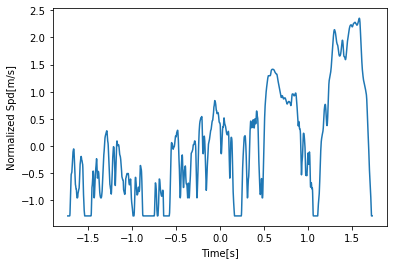

In [3]:
seq= load_data()

plt.close('all')
plt.figure(1)
plt.plot(seq[:,1],seq[:,0])
plt.xlabel('Time[s]')
plt.ylabel('Normalized Spd[m/s]')

In [13]:
# LSTM网络包装函数
class BatchLSTM(nn.Module):
    def __init__(self, inp_dim, out_dim, mid_dim, mid_layers):
        super(BatchLSTM, self).__init__()

        self.rnn = nn.LSTM(inp_dim, mid_dim, mid_layers)  # rnn
        self.reg = nn.Sequential(
            nn.Linear(mid_dim, mid_dim),
            nn.Tanh(),
            nn.Linear(mid_dim, out_dim),
        )  # regression

        # x = feature
    def forward(self, x):
        y = self.rnn(x)[0]  # y, (h, c) = self.rnn(x)

        seq_len, batch_size, hid_dim = y.shape
        y = y.view(-1, hid_dim)
        y = self.reg(y)
        y = y.view(seq_len, batch_size, -1)
        return y

    def output_y_hc(self, x, hc):
        y, hc = self.rnn(x, hc)  # y, (h, c) = self.rnn(x)

        seq_len, batch_size, hid_dim = y.size()
        y = y.view(-1, hid_dim)
        y = self.reg(y)
        y = y.view(seq_len, batch_size, -1)
        return y, hc

In [5]:
# 数据处理（数据切割至Bin）

seq =  load_data();
def process_data(data, seq_len):
    """
        根据给定的序列data，生成数据集
        
        数据集分为输入和输出，每一个输入的长度为seq_len，每一个输出的长度为1。
        也就是说用seq_len天的数据，对应下一天的数据。
 
        若给定序列的长度为d，将输出长度为(d-seq_len+1)个输入/输出对
    """
    dataset_x , dataset_y = [],[]
    for i in range(len(data)-seq_len-1): # 1在此处是被预测帧，即y中对应值
        _x = data[i:i+seq_len]
        dataset_x.append(_x) #输入
        dataset_y.append(data[i+seq_len+1]) #输出
    return (np.array(dataset_x), np.array(dataset_y))
    
data_batch  = process_data(seq,10);


In [37]:
# 预测过程
def run_DC():
    inp_dim = 8 # 输入几帧数据
    out_dim = 1 # 预测几帧数据
    mod_dir = '.'

    '''load data'''
    data = load_data()  # axis1: number, year, month
    #data_x = np.concatenate((data[:-2, 0:1], data[+1:-1, 0:1]), axis=1)
    #data_y = data[2:, 0]
    data_x, data_y  = process_data(data, inp_dim);
    
    train_size = int(len(data_x) * 0.7)
    train_x = data_x[0:train_size]
    train_y = data_y[0:train_size]

    # (seq, batch, feature)
    train_x = train_x.reshape((-1, 1, inp_dim)) # change from (N,3) to (N,1,3)
    train_y = train_y.reshape((-1, 1, out_dim))

    '''build model'''
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    net = BatchLSTM(inp_dim, out_dim, mid_dim= 16, mid_layers=8).to(device)
    criterion = nn.SmoothL1Loss()
    optimizer = torch.optim.Adam(net.parameters(), lr=1e-2)

    '''train'''
    var_x = torch.from_numpy(train_x)
    var_y = torch.from_numpy(train_y)
    #var_x = torch.tensor(train_x, dtype=torch.float32, device=device)
    #var_y = torch.tensor(train_y, dtype=torch.float32, device=device)
    #print('var_x.size():', var_x.size())
    #print('var_y.size():', var_y.size())

    for e in range(1024):
        out = net(var_x.float())
        loss = criterion(out, var_y.float())
       # loss = compute_all_loss() 使用自定义的loss函数

        loss.backward()
        optimizer.step()
        optimizer.zero_grad()
        if (e + 1) % 100 == 0:  # 每 100 次输出结果
            print('Epoch: {}, Loss: {:.5f}'.format(e + 1, loss.item()))

    torch.save(net.state_dict(), '{}/net_DC.pth'.format(mod_dir))


In [38]:
def run_eval():
    inp_dim = 8
    out_dim = 1
    mod_dir = '.'    
        
    '''load data'''
    data = load_data() 
    data_x, data_y  = process_data(data, inp_dim);
    data_x = data_x.astype(float)
    data_y = data_y.astype(float) 

    data_x = data[:, :] # all data set
    data_y = data[:, 0] #速度信息
    
    train_size = int(len(data_x) * 0.9)
    train_x = data_x[0:train_size]
    train_y = data_y[0:train_size]

    
    train_x = train_x.reshape((-1, 1, inp_dim)) # change from (N,2) to (N,1,2)
    train_y = train_y.reshape((-1, 1, out_dim))
    
    '''eval'''
    net = BatchLSTM(inp_dim, out_dim, mid_dim=16, mid_layers=8);
    net.load_state_dict(torch.load('{}/net_DC.pth'.format(mod_dir), map_location=lambda storage, loc: storage))
    net.eval()  # 转换成测试模式
    
    """
    appropriate way of seq prediction:
    """
    test_x = data_x.reshape((-1, 1, inp_dim))
    test_x_in = np.copy(test_x);
    #print(test_x_in) 
    test_x_in[train_size:,0,0] = 0  # 删去需要预测的速度信息
    #print(test_x_in) 
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    test_x_in = torch.tensor(test_x_in, dtype=torch.float32, device=device)
    for i in range(train_size, len(data) - 1):
        test_y = net(test_x_in[:i].float) # predict 速度
        test_x_in[i, 0, 0] = test_y[-1, 0] #将上一帧的预测量作为输入数据的一部分

    pred_y = test_x_in.cpu().data.numpy()
    pred_y = pred_y[:, 0, 0]
    plt.plot(data_y, 'r', label='real', alpha=0.3)
    plt.plot([train_size, train_size], [-1, 2], label='train | predict')
    plt.plot(pred_y[2:], 'g', label='predict')
    plt.legend(loc='best')
    plt.savefig('lstm.png')
    plt.pause(4)

In [ ]:
if __name__ == '__main__':
    run_DC()
    run_eval()
    
    #run_origin_Demo()

Epoch: 100, Loss: 7.61530
Epoch: 200, Loss: 10.24605
Epoch: 300, Loss: 7.42152
Epoch: 400, Loss: 7.28316
